# Warehouse Product Location Optimizer

Imagine this common scenario: A warehouse manual fills customer orders by printing a list of products on the order and handing them to an employee. The employee wanders around the warehouse shelves looking for the products on the list, picking them from the bin, and returning to the shipping station to package and ship the order. Perhaps there is a little more intelligence in the system that tells the employee which location, shelf, and bin the products are located in. In that case, the employee walks between each location and picks the products from the correct shelf and bin.

I simulate this scenario with a random set of products and locations. I analyze the product patterns based on a random set of "customer orders". Assuming that all of the products are stored in identical bins, I optimize the location of the products based on the product order history. This optimization is implemented in the factory by rearranging the product bins to reduce the travel distance required to fill all of the orders (reducing the average walk distance and time).

The final step is to show the improvement in the distance it takes to pick the orders.

## Warehouse Arangement

I assume that the warehouse is arranged in a straight line and the product storage is divided into three types of identifiers:

* Location: which shelving unit is the product located in? The shelving unit has 3 shelves that hold 4 bins on each shelf.
* Shelf: on which shelf on the shelving unit is the product located?
* Bin: Which bin is the product in on the shelf?

The optimizer works to mimize the distance traveled to fill the orders on average. It tests this by randomly swapping the locations of two products. If the distance is reduced, the swap might be kept (based on a pseduo-anneal process). Though this optimization is not guaranteed to find the best arrangement of products, it typically finds a good arrangment.

In [1]:
# Library imports
import numpy as np
from scipy.stats import pareto
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from copy import deepcopy
from time import time

## Product Order History Simulation

The first step is to create a simulated set of products and a history of product orders. The simulation will use `n_products=100` different products and will model a Pareto-like product distribution where 80% of the customer orders come in for the same 20% of products. 

Some products might be ordered multiple times on the same order - this is accounted for by the product quantity line. Because this only requires picking more than one product from the same bin, I do not consider quantities higher than 1 when calculating the total distance.




Pareto: 80% of orders in top 20% of products


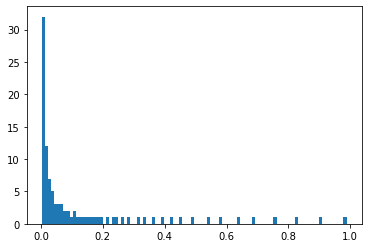

In [2]:
# Set the total number of unique products
n_products = 100

# Set the random seed for the random number generator
np.random.seed(42)

# The Pareto probability distribution is based on a single parameter. 
# b = 4.9 gives the 80/20 relationship for the product orders.
pareto_b = 4.9

# Set up a probability distribution for the product orders
x = np.linspace(pareto.ppf(0.01, pareto_b), pareto.ppf(0.99, pareto_b), n_products + 1)
product_order_probability = pareto.pdf(x, pareto_b)/pareto_b

# Turn this into a sorted probability threshold list
# To determine if the product is orders, we will get a random number (0,1): the 
# largest entry that is less than the random number will be the product we ordered. 
# If there are duplicates, that means we ordered multiple quantities of that product

# Sort and get the cumulative probability for the distribution
product_prob_limits = np.cumsum(np.flip(np.diff(np.flip(product_order_probability))))

# Finally, we check that we are within the 80/20 limit. If we change the pareto_b parameter, this will shift
print("Pareto: 80% of orders in top {}% of products".format(int(100 * np.argmax(product_prob_limits > 0.8) / (n_products))))
plt.hist(product_order_probability, bins=100);

Next we set up a helper function that generates a random order. We get a random number of items in each order. Our simulation assumes that customers tend to request between 2 and 6 items on each order.

In [3]:
def get_order(order_min=2, order_max=6):
    """ Helper function to generate a sample order of items following the 
    product_order_probability distribution. """
    
    # Generate the random list of numbers between 0 and 1
    order_prob = np.random.rand(np.random.randint(2, 6)).reshape(-1,1)
    
    # Get the list of products that belong to those probabilities
    order_n = np.argmin(order_prob < product_order_probability, axis=1) - 1
    
    # Return the order item numbers for this simulated order
    return order_n[order_n >= 0]

# Test the function
get_order()

array([ 2, 21,  2,  5], dtype=int64)

We look at the results of multiple orders. The end result should be that about 20% of the products make up 80% of the orders. We look at what fraction of products make up the 80% of the orders to verify that our random order generator is working properly.

In [4]:
(pn, pnv) = np.unique(np.concatenate([get_order() for _ in range(70000)]), return_counts=True)
np.argmax(np.cumsum(pnv / pnv.sum()) > 0.8) / len(pnv)

0.19

## Warehouse Product Location Simulation

We have three tiers of product locations:

1. Location
2. Shelf
3. Bin

We identify the location on a line separated by integer lenghts (i.e. location 1, 2, 3, ...). Because the warehouse is laid out along a line, this corresponds to a physical relationship between the locations (1 is next to 2 and 3 is twice as far from 1 as 2). We treat this as the `x` direction in the distance.

The shelf location is a different axis that we assign to a `y` direction. The shelves are much closer together and there are 3 shelves in each location. The three shelves are located at `[0.0, -0.2, 0.2]` corresponding roughly to cart-height (zero) and a shelf above and below that.

Finally, the bins are a third axis that we assign to a `z` direction. There are 4 bins on each shelf and are assigned locations `z = [-0.03, -0.01, 0.01, 0.03]`. 

The net result of the distance calculation is something like this:

* Moving between adjacent locations is a distance of 1
* Moving within a single location to a different shelf (same bin position) is 0.2
* Staying on the same shelf, but moving between bins is 0.02


In [5]:
n_bins_per_shelf = 4
bin_distance = 0.02

n_shelves_per_location = 3
shelf_distance = 0.2

location_distance = 1.0

def get_locations(n, n_dist):
    if n % 2 == 0:
        locs = np.linspace(- (n - 1) / 2 * n_dist, (n - 1) / 2 * n_dist, n) 
    else:
        locs = np.linspace(-np.floor(n/2) * n_dist, np.floor(n/2) * n_dist, n) 
    return locs

shelves = get_locations(n_shelves_per_location, shelf_distance)
bins = get_locations(n_bins_per_shelf, bin_distance)

n_locations = int(np.ceil(n_products / (n_bins_per_shelf * n_shelves_per_location)))
locations = np.arange(1.0, n_locations + 1.0, 1.0)

# So the total number of bin tuples is:
product_locations = [(i, j , k) for i in locations for j in shelves for k in bins][:n_products]

# And now we start with a randomized location
np.random.shuffle(product_locations)


## Simulated Orders

We now create a dateframe of order lines. Each order is a random collection of products that are stored in the random locations.

In [6]:
n_orders = 30000

df_fol = pd.DataFrame([{'order_number':i + 1, 
                        'order_line':j + 1, 
                        'order_item':k,
                        'order_location':product_locations[k][0],
                        'order_shelf':product_locations[k][1],
                        'order_bin':product_locations[k][2]} 
                       for i in range(n_orders) 
                       for j,k in enumerate(get_order())])

# Count up any duplicates and give those orders a quantity greater than 1
df_fol = df_fol.groupby(['order_number', 'order_item','order_location', 'order_shelf','order_bin']).\
    count().\
    reset_index(drop=False).\
    rename(columns={'order_line':'order_qty'})

# Fix the order line number to be based on order_item number (counting up)
df_fol['order_line'] = df_fol.\
    groupby(['order_number']).\
    cumcount() + 1


# Display the first few rows of our simulated order history
df_fol.head()

,order_number,order_item,order_location,order_shelf,order_bin,order_qty,order_line
0,1,0,9.0,-0.2,-0.03,1,1
1,1,14,2.0,-0.2,-0.03,1,2
2,2,1,5.0,0.0,-0.01,2,1
3,2,8,6.0,0.0,0.01,1,2
4,2,29,3.0,-0.2,-0.01,1,3


We'll check the orders to make sure they have the right properties. First: how many products were placed on each order? This should be between 2 and 6. There may be a few orders that only have one item where they ordered duplicates.

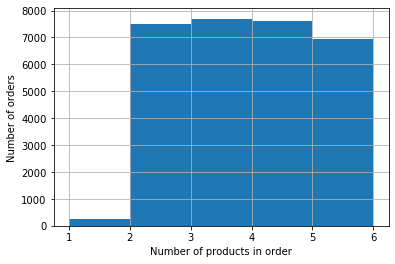

In [7]:
df_fol.groupby('order_number')['order_qty'].sum().hist(bins=[1,2,3,4,5,6])
plt.xlabel("Number of products in order")
plt.ylabel("Number of orders");

And we verify that we have the correct Pareto distribution

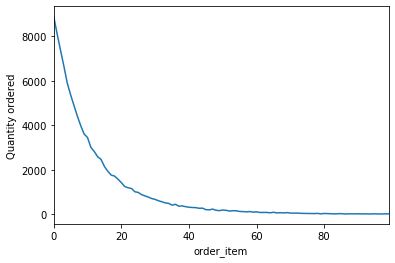

In [8]:
df_fol.groupby('order_item')['order_qty'].sum().plot()
plt.ylabel("Quantity ordered");

The top 20% of items should be 80% of the orders. We are really close.

In [9]:
(df_fol.groupby('order_item')['order_qty'].sum().cumsum() / (df_fol['order_qty'].sum()))[:int(n_products/5)].tail()

order_item
15    0.731905
16    0.750614
17    0.767679
18    0.784301
19    0.799598
Name: order_qty, dtype: float64

## Order Fulfillment Distances

Now we need to get the prior location in the order (to estimate the distances between orders). We use the `shift()` function to get the prior location. We also fill in the inital location as `0,0,0` indicating that we are at the shipping location.

The prior item will be filled as `-1` indicating that we are at the first line of the order.

In [10]:
df_fol['prior_item'] = df_fol.\
    groupby(['order_number'])['order_item'].\
    shift(1)

df_fol = df_fol.fillna(-1)
df_fol['prior_item'] = df_fol['prior_item'].astype('int64')

df_fol['prior_location'] = df_fol.\
    groupby(['order_number'])['order_location'].\
    shift(1)

df_fol['prior_shelf'] = df_fol.\
    groupby(['order_number'])['order_shelf'].\
    shift(1)

df_fol['prior_bin'] = df_fol.\
    groupby(['order_number'])['order_bin'].\
    shift(1)

df_fol = df_fol.fillna(0.0)

df_fol.head(10)

,order_number,order_item,order_location,order_shelf,order_bin,order_qty,order_line,prior_item,prior_location,prior_shelf,prior_bin
0,1,0,9.0,-0.2,-0.03,1,1,-1,0.0,0.0,0.00
1,1,14,2.0,-0.2,-0.03,1,2,0,9.0,-0.2,-0.03
2,2,1,5.0,0.0,-0.01,2,1,-1,0.0,0.0,0.00
3,2,8,6.0,0.0,0.01,1,2,1,5.0,0.0,-0.01
4,2,29,3.0,-0.2,-0.01,1,3,8,6.0,0.0,0.01
5,3,3,1.0,-0.2,0.01,1,1,-1,0.0,0.0,0.00
6,3,5,6.0,0.2,0.01,1,2,3,1.0,-0.2,0.01
7,3,16,7.0,0.2,0.01,1,3,5,6.0,0.2,0.01
8,4,7,3.0,0.0,-0.01,1,1,-1,0.0,0.0,0.00
9,4,11,7.0,-0.2,-0.01,1,2,7,3.0,0.0,-0.01


# Network graph

We can now map out the relationship between products on the orders. We map this as a network graph that shows how many times the employee has to walk between any two locations.

We first need to get the counts of the change in locations- but we want to get this as a total number independent of whether where we started or ended - just the number of times we went between two locations.

In [11]:
def show_network(config):
    """Helper function to show the frequency of orders moving between locations"""
    
    config['location_change'] = config.apply(lambda x: '|'.join([str(y) for y in sorted((x['order_location'],x['prior_location']))]), axis='columns')
    config_weights = (config.groupby('location_change')['order_qty'].count()).reset_index(drop=False)
    config_weights['weight'] = config_weights['order_qty'] / len(df_fol)

    G = nx.Graph()
    for i,row in config_weights.iterrows():
        G.add_edge(row['location_change'].split("|")[0], row['location_change'].split("|")[1], weight=row['weight']*100)

    # use one of the edge properties to control line thickness
    edgewidth = [ d['weight'] for (u,v,d) in G.edges(data=True)]

    # layout
    pos = nx.spring_layout(G, iterations=1000)
    #pos = nx.random_layout(G)
    dist = nx.shortest_path_length(G, weight='weight')
    pos = nx.kamada_kawai_layout(G, dist=dist, pos=pos)

    # rendering
    plt.figure(figsize=(10,8))
    plt.axis('off')
    nx.draw_networkx_nodes(G, pos, node_color='#55ff55')
    nx.draw_networkx_edges(G, pos, width=edgewidth, edge_color='#0000ff');
    nx.draw_networkx_labels(G, pos);

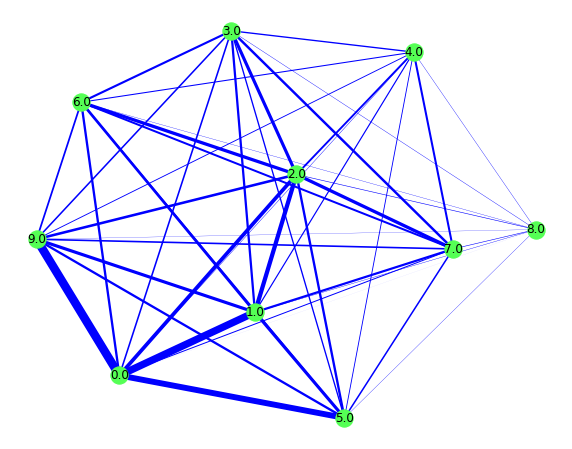

In [12]:
show_network(df_fol)

Of course this isn't optimized at all! Before we work on that, let's get the average distance traveled to fill the order.

In [13]:
df_fol['dist'] = np.sqrt( (df_fol['order_location'] - df_fol['prior_location'])**2 + 
                        (df_fol['order_shelf'] - df_fol['prior_shelf'])**2 + 
                        (df_fol['order_bin'] - df_fol['prior_bin'])**2 )
df_fol.head()

,order_number,order_item,order_location,order_shelf,order_bin,order_qty,order_line,prior_item,prior_location,prior_shelf,prior_bin,location_change,dist
0,1,0,9.0,-0.2,-0.03,1,1,-1,0.0,0.0,0.00,0.0|9.0,9.002272
1,1,14,2.0,-0.2,-0.03,1,2,0,9.0,-0.2,-0.03,2.0|9.0,7.000000
2,2,1,5.0,0.0,-0.01,2,1,-1,0.0,0.0,0.00,0.0|5.0,5.000010
3,2,8,6.0,0.0,0.01,1,2,1,5.0,0.0,-0.01,5.0|6.0,1.000200
4,2,29,3.0,-0.2,-0.01,1,3,8,6.0,0.0,0.01,3.0|6.0,3.006726


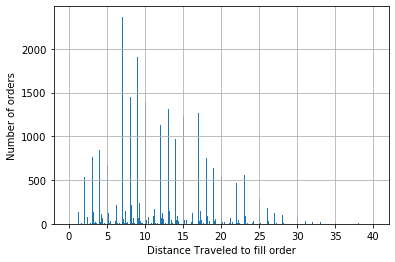

In [14]:
df_order_dist = df_fol.groupby('order_number')['dist'].sum()
df_order_dist.hist(bins=np.arange(0,df_order_dist.max(),0.1))
plt.xlabel("Distance Traveled to fill order")
plt.ylabel("Number of orders");

We also look at the summary statistics: The average order requires quite a bit of walking with our unoptimized layout.

In [15]:
df_fol.groupby('order_number')['dist'].sum().describe()

count    29997.000000
mean        11.943258
std          6.210825
min          1.000450
25%          7.040010
50%         11.019974
75%         16.034082
max         40.015361
Name: dist, dtype: float64

## Monte Carlo Pseduo-anneal Optimization

Now we start to trade bins around and see how that improves the overall distances we have to go in order to fill the orders. We define a number of helper functions to run this optimization.

In [16]:
def get_current_temperature(iteration, s_curve_amplitude, s_curve_center, s_curve_width):
    """Temperature anneal based on an s-curve"""
    return s_curve_amplitude * calculate_s_curve(iteration, s_curve_center, s_curve_width)
    
def calculate_s_curve(x, center, width):
    """Calculate the s-curve amplitude"""
    return 1 / (1 + np.exp((x - center) / width))

def score_arrangement(config):
    """Score a product location arrangement based on the average distance per order"""
    total_score = config.groupby('order_number')['dist'].sum().mean()
    return total_score

def product_swap(initial_config):
    """Swap the locations of two products."""
    
    trial_config = initial_config.copy()
    product_1, product_2 = np.random.choice(range(n_products), 2, replace=False)

    # Get the locations of the first and second products

    order_location_1, order_shelf_1, order_bin_1 = initial_config[initial_config['order_item'] == product_1].head(1)[['order_location','order_shelf','order_bin']].values[0]
    order_location_2, order_shelf_2, order_bin_2 = initial_config[initial_config['order_item'] == product_2].head(1)[['order_location','order_shelf','order_bin']].values[0]
    
    # Swap all of product_1's locations
    trial_config.loc[trial_config['order_item'] == product_1, ['order_location','order_shelf','order_bin']] = (order_location_2, order_shelf_2, order_bin_2)
    trial_config.loc[trial_config['prior_item'] == product_1, ['prior_location','prior_shelf','prior_bin']] = (order_location_2, order_shelf_2, order_bin_2)
    
    # Swap all of product_2's locations
    trial_config.loc[trial_config['order_item'] == product_2, ['order_location','order_shelf','order_bin']] = (order_location_1, order_shelf_1, order_bin_1)
    trial_config.loc[trial_config['prior_item'] == product_2, ['prior_location','prior_shelf','prior_bin']] = (order_location_1, order_shelf_1, order_bin_1)
   
    # Recalculate the distance column
    trial_config['dist'] = np.sqrt( (trial_config['order_location'] - trial_config['prior_location'])**2 + 
                        (trial_config['order_shelf'] - trial_config['prior_shelf'])**2 + 
                        (trial_config['order_bin'] - trial_config['prior_bin'])**2 )
    
    return trial_config


def run_intermediate_anneal(factory_config, 
                            factory_score, 
                            best_config, 
                            best_score,
                            starting_iteration, 
                            number_of_iterations, 
                            s_curve_amplitude, 
                            s_curve_center, 
                            s_curve_width):
    """Split the anneal into pieces that are handled one at a time.
    
    This intermediate anneal runs for a fixed number of iterations and tries various product swaps.
    
    If the swap leads to an improved score, it is kept. Otherwise it may or may not be kept,
    depending on the temperature.
    
    """
    
    score_history = np.zeros(number_of_iterations)

    for i in range(number_of_iterations):
              
        iteration = starting_iteration + i 
        
        temp = get_current_temperature(iteration, s_curve_amplitude, s_curve_center, s_curve_width)
        
        #try a swap: if it is a good swap, we'll keep it later
        candidate_config = product_swap(factory_config)
        
        #score the overall configuration based on this update
        candidate_score = score_arrangement(candidate_config)

        if temp > 0:
            #This tends to 1 
            ratio = np.exp(-(candidate_score - factory_score) / temp)
        else:
            #At zero temp, we only keep good flips
            ratio = 1.0 * (candidate_score > 0)
        
        
        #Get a random number: if it is less than our ratio, keep the flip
        if np.random.rand() < ratio:
            factory_config = candidate_config
            factory_score = candidate_score

            if (factory_score < best_score):
                best_config = factory_config
                best_score = factory_score
        
        score_history[i] = factory_score
        
    iteration_result = {
        "factory_config": factory_config,
        "factory_score": factory_score,
        "best_config": best_config,
        "best_score": best_score,
        "score_history": score_history}
        
    return iteration_result


def main(initial_config, show_plots=True, steps_per_iteration=600):
    
    #Determine the number of temperature steps to take based on the number of hands
    print_iterations = int(0.1 * n_products)
   
    number_of_iterations = print_iterations * steps_per_iteration
    starting_iteration = 1
    
    # Set up temperature parameters
    t_max = 5
    t_center = number_of_iterations*0.15
    t_width = number_of_iterations*0.2
    
    if show_plots:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        ax1.plot([np.exp(-1/get_current_temperature(iteration, t_max, t_center, t_width)) for iteration in range(number_of_iterations)])
        ax1.set_xlabel("Iteration number")
        ax1.set_ylabel("Pseudo-temperature")
        ax1.set_title("Annealing temperature curve")

    #Set the current configuration as our input cardDF
    factory_config = initial_config
    original_score = score_arrangement(initial_config)
    factory_score = original_score

    best_config = factory_config
    best_score = factory_score
    anneal_results = None
    score_history = np.zeros(steps_per_iteration * print_iterations)

    for i in range(print_iterations):
        start_time = time()

        iteration = steps_per_iteration * i
        anneal_results = run_intermediate_anneal(factory_config, factory_score, best_config, best_score,
                                                iteration, 
                                                steps_per_iteration, 
                                                t_max, 
                                                t_center, 
                                                t_width)

        best_config = anneal_results["best_config"]
        best_score = anneal_results["best_score"]

        factory_config = anneal_results['factory_config']
        factory_score = anneal_results['factory_score']

        score_history[(iteration):(iteration+steps_per_iteration)] = anneal_results["score_history"]
        end_time = time()
        time_taken = end_time - start_time
        print("Round {} of {} with score {} in time {}".format(i+1,print_iterations,best_score, time_taken))
    
    print("Max score of {}".format(best_score))
    if show_plots:
        ax2.plot(score_history)
        ax2.set_xlabel("Iteration Number")
        ax2.set_ylabel("Iteration Score")
        ax2.set_title("Score History")
        plt.tight_layout()
        
    return best_config


Round 1 of 10 with score 8.111317198128985 in time 33.414965867996216
Round 2 of 10 with score 7.966150815027217 in time 43.42107558250427
Round 3 of 10 with score 7.966150815027217 in time 47.596543073654175
Round 4 of 10 with score 7.646915076285576 in time 36.7024507522583
Round 5 of 10 with score 7.429954621796984 in time 49.75247240066528
Round 6 of 10 with score 6.618783426700412 in time 38.02249789237976
Round 7 of 10 with score 6.169021342595981 in time 36.139240980148315
Round 8 of 10 with score 5.915935525215731 in time 36.78170919418335
Round 9 of 10 with score 5.291507269297334 in time 37.16904163360596
Round 10 of 10 with score 4.725047649952568 in time 35.521048069000244
Max score of 4.725047649952568


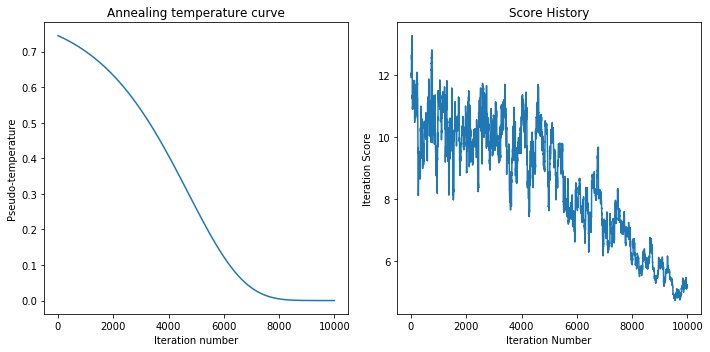

In [22]:
final_config = main(df_fol, steps_per_iteration=1000)

Updated network graph: we now see that most of the paths are simplified to a couple of close-by routes. 

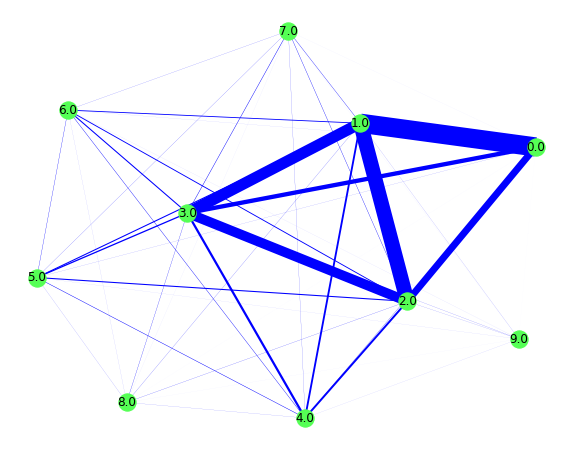

In [23]:
show_network(final_config)

The histogram of order distances shows a similar improvement.

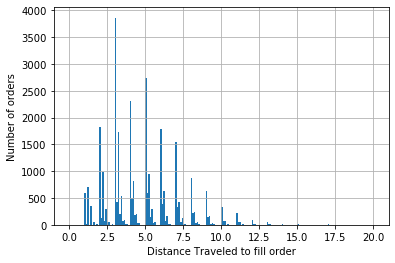

In [24]:
df_order_dist = final_config.groupby('order_number')['dist'].sum()
df_order_dist.hist(bins=np.arange(0,df_order_dist.max(),0.1))
plt.xlabel("Distance Traveled to fill order")
plt.ylabel("Number of orders");

Finally, our summarly statistics show how much we've reduced the distances required to fill the orders.

In [25]:
final_config.groupby('order_number')['dist'].sum().describe()

count    29997.000000
mean         4.725048
std          2.344313
min          1.000050
25%          3.039953
50%          4.211436
75%          6.075867
max         20.019674
Name: dist, dtype: float64